In [ ]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.59.6
    Uninstalling openai-1.59.6:
      Successfully uninstalled openai-1.59.6


In [ ]:
import os
import json
import openai
import base64
from PIL import Image
from io import BytesIO
import zlib

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

openai.api_key = ""

In [ ]:
def load_training_data(example_folder):
    """
    Load the training data from example folder and save the iamges in base64.
    Args:
        example_folder (str): folder path
    Returns:
        list: training data list，every element is a dictionary contains compound, sentence, images and ranking.
    """
    training_examples = []

    images_folder = os.path.join(example_folder, "images")
    compound_sentence_file = os.path.join(example_folder, "train_pie_sent.json")
    ranking_file = os.path.join(example_folder, "standard_ranking.json")

    # check if the folders exist
    if not os.path.exists(images_folder):
        raise FileNotFoundError(f"Images folder not found in {example_folder}.")
    if not os.path.exists(compound_sentence_file):
        raise FileNotFoundError(f"Compound-sentence file not found in {example_folder}.")
    if not os.path.exists(ranking_file):
        raise FileNotFoundError(f"Ranking file not found in {example_folder}.")

    # read compound-sentence dict
    with open(compound_sentence_file, "r") as f:
        compound_sentences = json.load(f)

    # read standard ranking
    with open(ranking_file, "r") as f:
        standard_rankings = json.load(f)

    # read the iamges
    for filename in os.listdir(images_folder):
        if filename.lower().endswith("_merged_format_compress.png"):
            # extract compound
            compound = filename.split("_merged_format_compress.png")[0]

            # check if the compound has conrresponding sentence and ranking
            if compound in compound_sentences and compound in standard_rankings:
                sentence = compound_sentences[compound]
                ranking = standard_rankings[compound]

                # abtain the iamges and convert it to Base64
                image_path = os.path.join(images_folder, filename)
                with open(image_path, "rb") as img_file:
                  image_base64 = base64.b64encode(img_file.read()).decode("utf-8")
                # with Image.open(image_path) as img:
                #   img.thumbnail((640, 128), Image.Resampling.LANCZOS)  # 调整分辨率
                #   buffer = BytesIO()
                #   img.save(buffer, format="JPEG", quality=30)  # 保存为压缩的 JPEG
                #   buffer.seek(0)
                #   image_base64 = base64.b64encode(buffer.read()).decode("utf-8")
                #   compressed_data = zlib.compress(image_base64.encode('utf-8'))  # 压缩
                #   compressed_base64 = base64.b64encode(compressed_data).decode('utf-8')

                # append the entry
                training_examples.append({
                    "compound": compound,
                    "sentence": sentence,
                    "images": image_base64,
                    "ranking": ranking
                })
            else:
                print(f"Warning: No sentence or ranking found for compound '{compound}'.")

    return training_examples

In [ ]:
def load_evaluation_data(evaluation_folder):
    """
    Load the evaluation data from folder and save the iamges in base64.
    Args:
        example_folder (str): folder path
    Returns:
        list: evaluation data list，every element is a dictionary contains compound, sentence, images and ranking.
    """
    query_data = []

    images_folder = os.path.join(evaluation_folder, "images")
    compound_sentence_file = os.path.join(evaluation_folder, "test_pie_sent.json")

    # check if the folders exist
    if not os.path.exists(images_folder):
        raise FileNotFoundError(f"Images folder not found in {evaluation_folder}.")
    if not os.path.exists(compound_sentence_file):
        raise FileNotFoundError(f"Compound-sentence file not found in {evaluation_folder}.")

    # read compound-sentence dict
    with open(compound_sentence_file, "r") as f:
        compound_sentences = json.load(f)


    # read the iamges
    for filename in os.listdir(images_folder):
        if filename.lower().endswith("_merged_format_compress.png"):
            # extract compound
            compound = filename.split("_merged_format_compress.png")[0]

            # check if the compound has conrresponding sentence and ranking
            if compound in compound_sentences:
                sentence = compound_sentences[compound]

                # abtain the iamges and convert it to Base64
                image_path = os.path.join(images_folder, filename)
                with open(image_path, "rb") as img_file:
                 image_base64 = base64.b64encode(img_file.read()).decode("utf-8")
                # with Image.open(image_path) as img:
                  # img.thumbnail((640, 128), Image.Resampling.LANCZOS)  # 调整分辨率
                  # buffer = BytesIO()
                  # img.save(buffer, format="JPEG", quality=30)  # 保存为压缩的 JPEG
                  # buffer.seek(0)
                  # image_base64 = base64.b64encode(buffer.read()).decode("utf-8")
                  # compressed_data = zlib.compress(image_base64.encode('utf-8'))  # 压缩
                  # compressed_base64 = base64.b64encode(compressed_data).decode('utf-8')

                # append the entry
                query_data.append({
                    "compound": compound,
                    "sentence": sentence,
                    "images": image_base64,
                })
            else:
                print(f"Warning: No sentence or ranking found for compound '{compound}'.")

    return query_data

In [ ]:
def generate_prompt_with_images(training_data, evaluation):
    """
    According to the training data, generate many-shot-learning prompt。
    Args:
        training_data (list): a list contains compound, sentence, images（Base64), ranking of the images.
    Returns:
        str: prompt
    """
    examples = []
    for i, data in enumerate(training_data, 1):
        image_base64 = f"data:image/jpeg;base64,{data['images']}"

        # build examples
        example = (
            f"{i}. According to the meaning of the compound '{data['compound']}' "
            f"in the sentence '{data['sentence']}', the rank of the images "
            f"{image_base64} is {data['ranking']}."
        )
        examples.append(example)

    # build query
    query_base64 = f"data:image/jpeg;base64,{evaluation['images']}"
    query = (
        f"Query: According to the meaning of the compound '{evaluation['compound']}' "
        f"in the sentence '{evaluation['sentence']}', rank the order of the images {query_base64}."
        f"Output: [A list of the number of the images], for example: [1, 3, 4, 5, 2]"
    )

    # concatenate the prompt
    prompt = "Examples:\n" + "\n".join(examples) + "\n" + query
    return prompt


In [ ]:
def generate_prompt_with_images(training_data, evaluation):
    """
    Generate a many-shot-learning prompt with detailed task description according to the training data and evaluation query.

    Args:
        training_data (list): A list containing dictionaries with 'compound', 'sentence',
                              'images' (list of image names), and 'ranking'.
        evaluation (dict): A dictionary containing 'compound', 'sentence', and 'images' for the query.

    Returns:
        str: The formatted prompt with task description.
    """
    # Task description
    task_description = (
        "Task: Determine whether the given compound in the sentence is used idiomatically or literally. "
        "Based on your determination, rank the five provided images as follows:\n\n"
        "- The image most relevant to your interpretation should be ranked first.\n"
        "- If the compound is interpreted as 'literal,' place the image that reflects the compound's contextual meaning first, "
        "the one representing the idiomatic meaning in the penultimate position, and the irrelevant image last.\n"
        "- If the compound is interpreted as 'idiomatic,' prioritize the idiomatic meaning accordingly, while placing the literal representation "
        "in the penultimate position and irrelevant images last.\n"
    )

    # Build examples
    examples = []
    for i, data in enumerate(training_data, 1):
        image_list = f"data:image/png;base64,{data['images']}"
        example = (
            f"{i}. Compound: {{{data['compound']}}}; Sentence: {{{data['sentence']}}}; "
            f"Images: {{{image_list}}}; Ranking: {{{data['ranking']}}}."
        )
        examples.append(example)

    # Build query
    query_image_list = f"data:image/png;base64,{evaluation['images']}"
    query = (
        f"Query: Based on the compound {{{evaluation['compound']}}} and the sentence "
        f"{{{evaluation['sentence']}}}, provide the ranking for the images {{{query_image_list}}}."
        f"\nOutput Format: Provide only the ranking as a list, e.g., [1, 4, 3, 5, 2]."
    )

    # Concatenate the prompt
    prompt = task_description + "\nExamples:\n" + "\n".join(examples) + "\n\n" + query
    return prompt


In [ ]:
def call_gpt(prompt, model="gpt-4o-2024-11-20"):
    """
    call GPT-4o API
    Args:
        prompt (str): prompt。
        model (str): the model to be used
    Returns:
        str: output
    """
    response = openai.ChatCompletion.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant for ranking images based on the literal or idiomatic meaning of an idiom."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    return response['choices'][0]['message']['content']

In [ ]:
train_path = '/content/gdrive/MyDrive/CCL/GPT/training folder'
eval_path = '/content/gdrive/MyDrive/CCL/GPT/evaluation folder'
training_examples = load_training_data(train_path)
query_data = load_evaluation_data(eval_path)

In [ ]:
for i in training_examples:
  print(i['compound'])
  print(i['sentence'])
  print(i['ranking'])
print(training_examples[2]['ranking'])

dirty money
When dirty money disappears offshore, it becomes more difficult for governments to tackle corruption.
[5, 4, 2, 3, 1]
bear market
Our exposure to technology, sector bets, and decision to increase equity exposure during the depth of the bear market helped position the fund to outperform.
[3, 1, 4, 2, 5]
white elephant
Miami's original Metrorail line was a white elephant when it was built and it remains one today.
[5, 2, 1, 4, 3]
beached whale
One scene is the Strip, which he described as a beached whale, and the neighborhood dining scene, which is making successful efforts to adapt.
[3, 1, 4, 5, 2]
banana republic
They are a boogeyman he scares you with while he colludes with your enemies, turns your country into a banana republic and uses the office to enrich himself.
[4, 5, 1, 2, 3]
[5, 2, 1, 4, 3]


In [ ]:
print(len(training_examples))
print(len(query_data))

5
8


In [ ]:
with open('/content/gdrive/MyDrive/CCL/GPT/train_pie_idiom.json', 'r') as f:
    train_pie = json.load(f)
training_data = []
for i in training_examples:
  if i['compound'] in train_pie:
    training_data.append(i)
print(len(training_data))

5


Examples:
1. According to the meaning of the compound 'dirty money' in the sentence 'When dirty money disappears offshore, it becomes more difficult for governments to tackle corruption.', the rank of the images  is [5, 4, 2, 3, 1].
2. According to the meaning of the compound 'bear market' in the sentence 'Our exposure to technology, sector bets, and decision to increase equity exposure during the depth of the bear market helped position the fund to outperform.', the rank of the images  is [3, 1, 4, 2, 5].
Query: According to the meaning of the compound 'cold feet' in the sentence 'True, some investors may still have cold feet from the summer of five years prior and the consequential financial collapse.', rank the order of the images .Output: [A list of the number of the images], for example: [1, 3, 4, 5, 2]

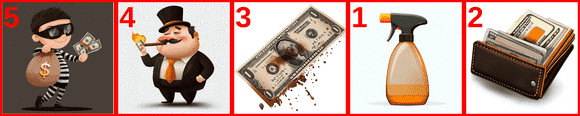
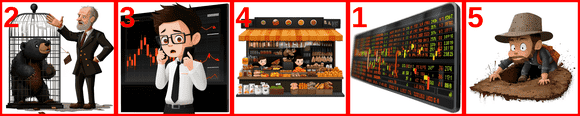
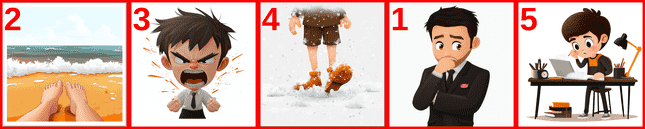

In [ ]:
prompt_4 = generate_prompt_with_images(training_data[:2], query_data[0])
print(prompt_4)

In [ ]:
cold_feet_rank = call_gpt(prompt_4)
print(cold_feet_rank)

To rank the images according to the idiomatic meaning of "cold feet" in the sentence, which refers to hesitation or fear of proceeding with something, I would need to analyze the visual content of the images. However, since I cannot view the images directly, I cannot provide a specific ranking. If you describe the images to me, I can help rank them based on their relevance to the idiom "cold feet."


In [ ]:
big_wig_rank = call_gpt(prompt_4)
print(big_wig_rank)

To rank the images according to the meaning of the compound "big wig" in the sentence, "He was married three times, was a mason, a championship level clay pigeon shooter and a big wig in the local Tory party," we focus on the idiomatic meaning of "big wig," which refers to an important or influential person, often in a political or organizational context.

Output: [3, 1, 5, 2, 4]
